In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

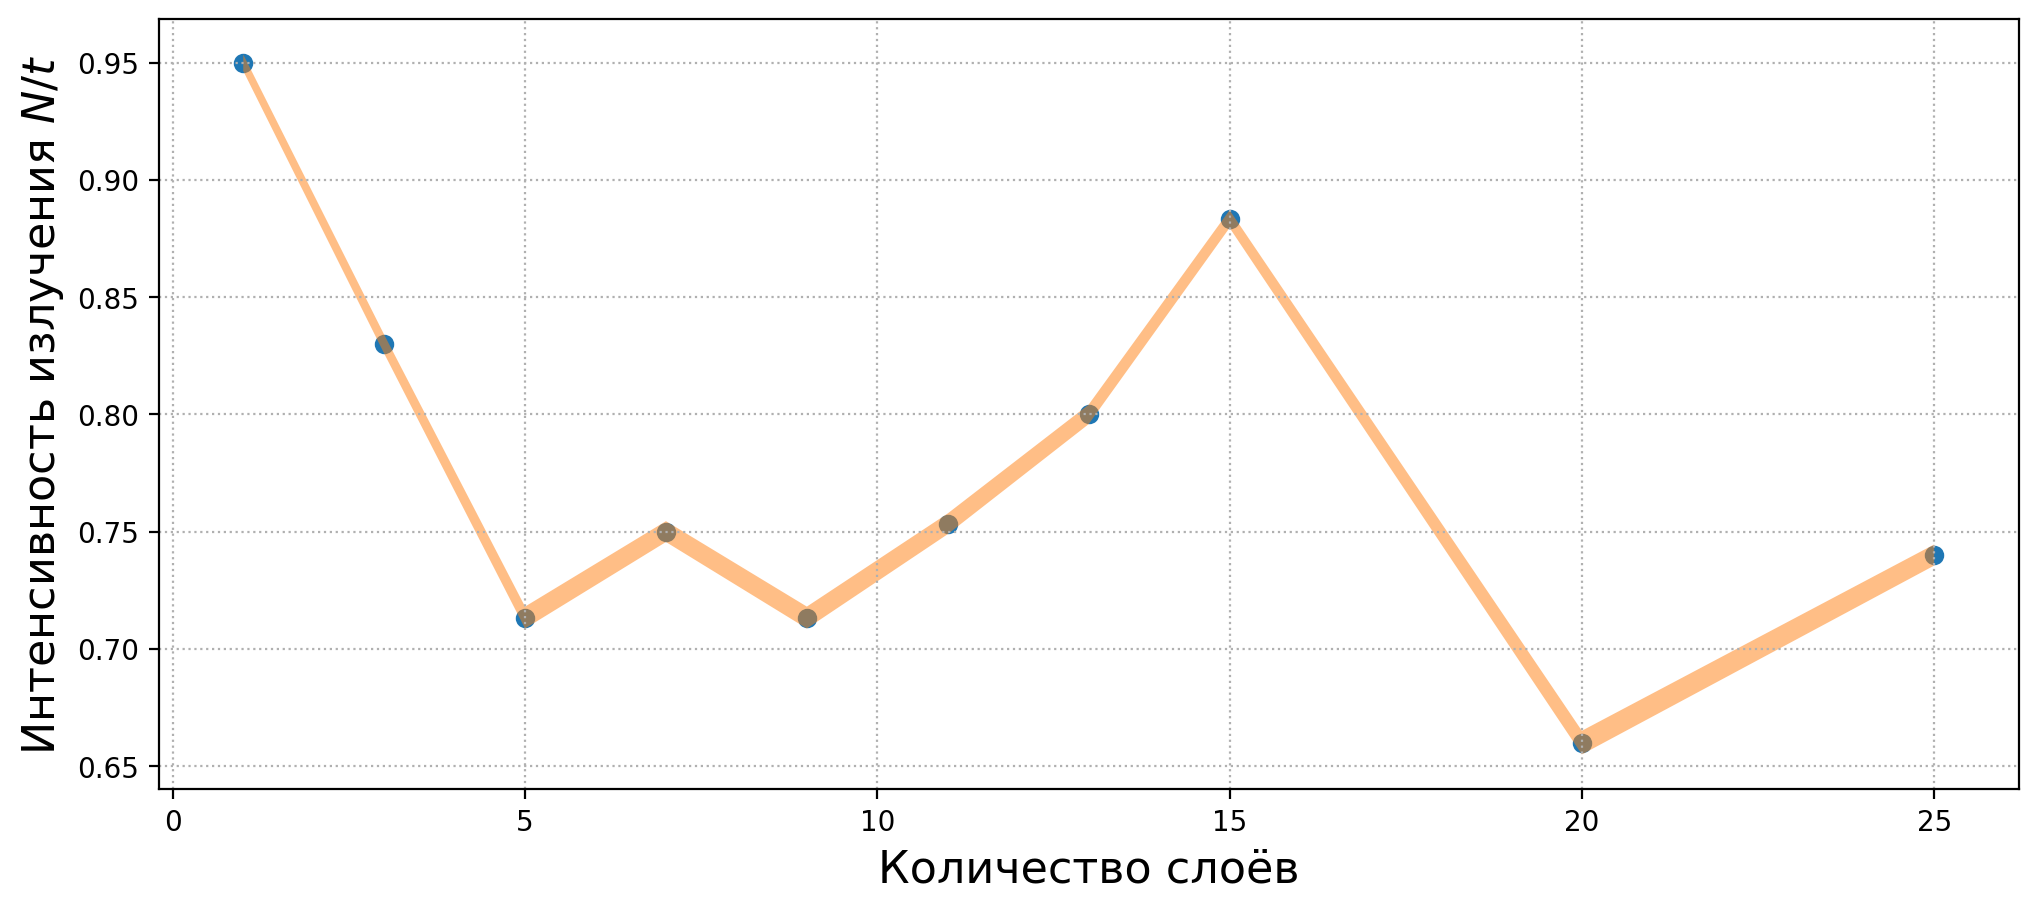

In [56]:
curve = pd.read_csv("curve.csv")

plt.figure(figsize = (12, 5), dpi = 200)
plt.scatter(curve.x, curve.N / curve.time)
plt.fill_between(curve.x, curve.N / curve.time + (1 / curve.N), curve.N / curve.time - (1 / curve.N), alpha = 0.5)

plt.ylabel("Интенсивность излучения $N/t$", fontsize = 16)
plt.xlabel("Количество слоёв", fontsize = 16)
plt.grid(ls = ':')

In [57]:
def curve_fit_func(x, a_line, b_line, a_exp, b_exp, c_exp, d):
    return (x < d) * a_exp * np.exp(b_exp * x) + c_exp + (x>=d) * x * a_line + b_line

In [58]:
param,_ = curve_fit(curve_fit_func, curve.x, curve.N / curve.time)
print(param[-1])

1.0000000014675734


/home/vladimir/BOTAY!/Labs/.venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


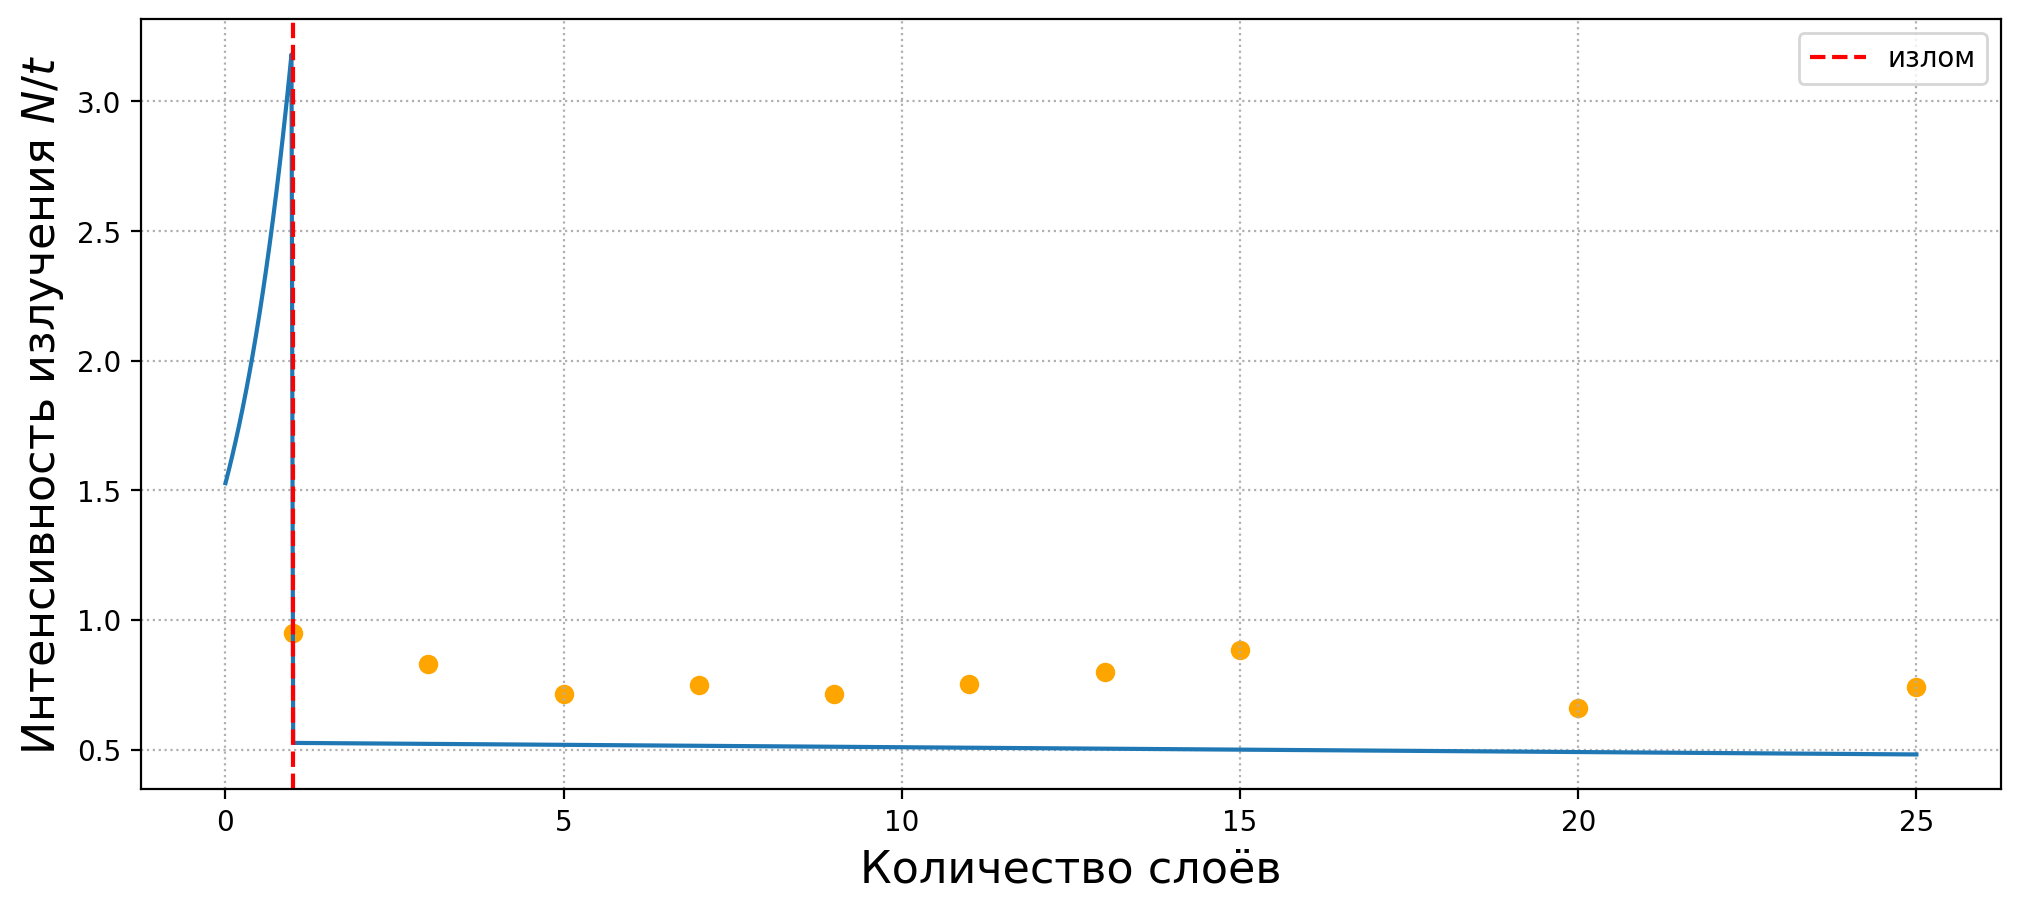

In [59]:
x_line = np.linspace(0, np.max(curve.x), 1000)
plt.figure(figsize = (12, 5), dpi = 200)
plt.grid(ls = ':')
plt.scatter(curve.x, curve.N / curve.time, color = 'orange')
plt.plot(x_line, curve_fit_func(x_line, *param))
plt.axvline(param[-1], color = 'red', label = 'излом', linestyle = '--')

plt.ylabel("Интенсивность излучения $N/t$", fontsize = 16)
plt.xlabel("Количество слоёв", fontsize = 16)
plt.legend()

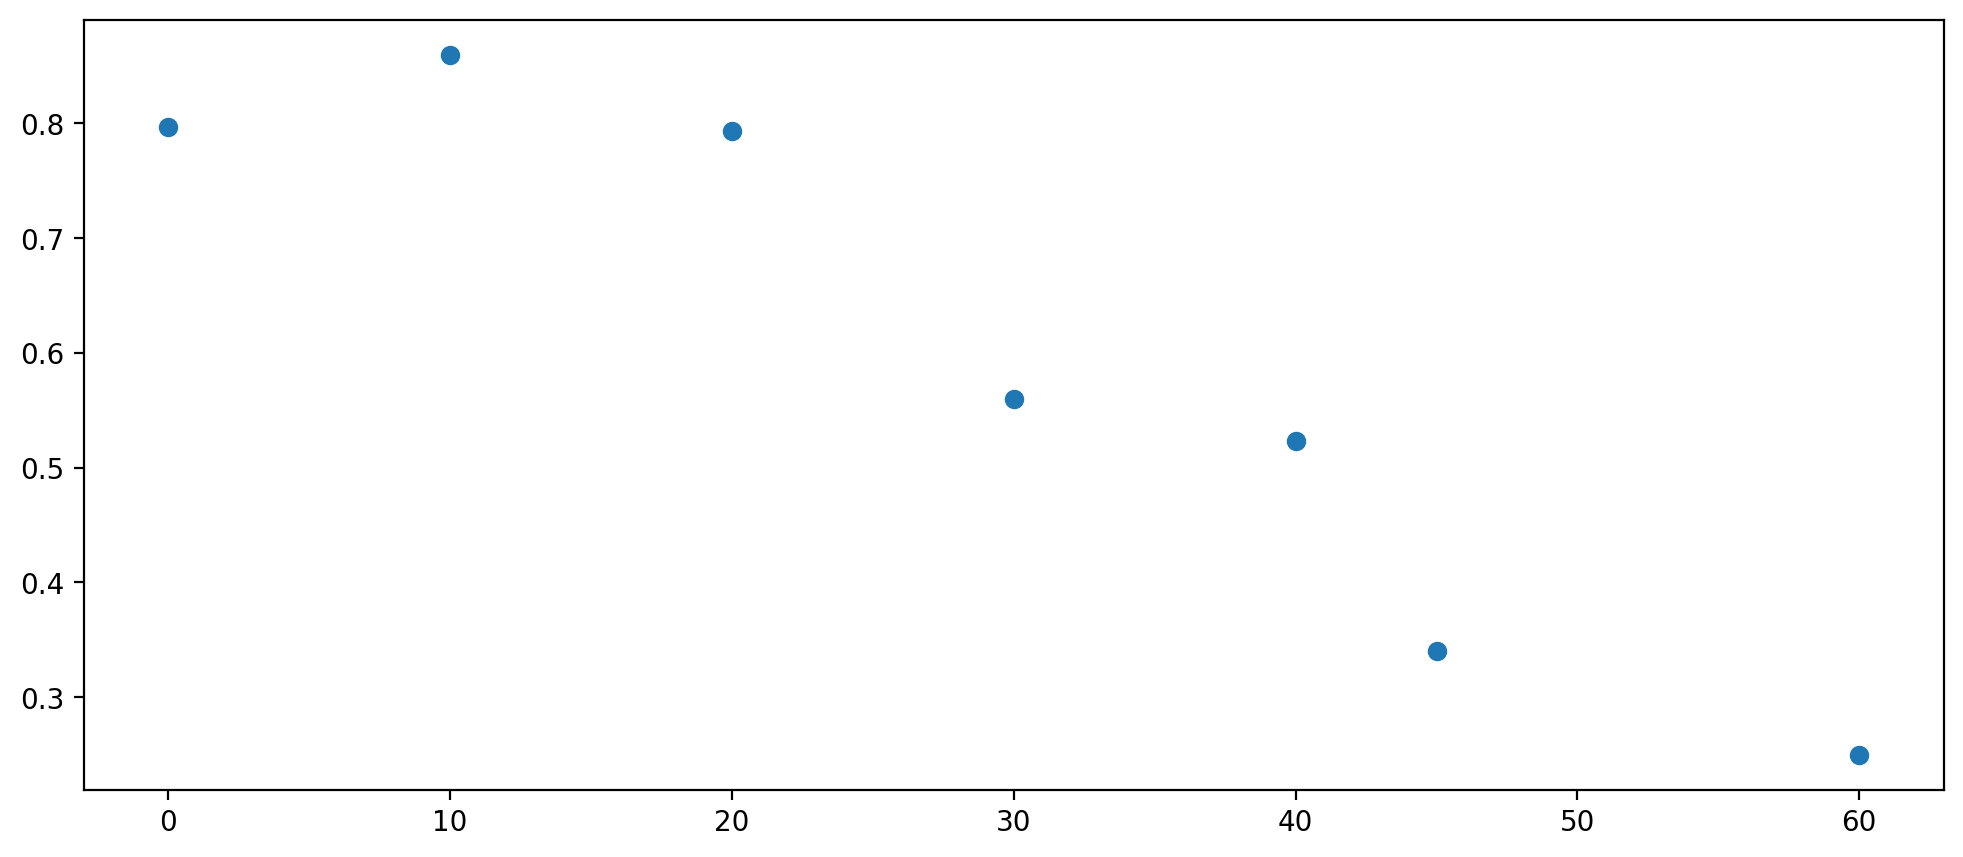

In [60]:
angle_spectrum = pd.read_csv("N_by_theta.csv")

plt.figure(figsize = (12, 5), dpi = 200)
plt.scatter(angle_spectrum.theta, angle_spectrum.N / angle_spectrum.time)